In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vivekdh112","key":"a6dbc00d0dea323c8143c7632e708afa"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle


In [4]:
!kaggle datasets download -d rohanrao/formula-1-world-championship-1950-2020

Dataset URL: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
License(s): CC0-1.0
  0% 0.00/6.28M [00:00<?, ?B/s]
100% 6.28M/6.28M [00:00<00:00, 850MB/s]


In [5]:
!unzip formula-1-world-championship-1950-2020.zip -d f1_data
!ls f1_data

Archive:  formula-1-world-championship-1950-2020.zip
  inflating: f1_data/circuits.csv    
  inflating: f1_data/constructor_results.csv  
  inflating: f1_data/constructor_standings.csv  
  inflating: f1_data/constructors.csv  
  inflating: f1_data/driver_standings.csv  
  inflating: f1_data/drivers.csv     
  inflating: f1_data/lap_times.csv   
  inflating: f1_data/pit_stops.csv   
  inflating: f1_data/qualifying.csv  
  inflating: f1_data/races.csv       
  inflating: f1_data/results.csv     
  inflating: f1_data/seasons.csv     
  inflating: f1_data/sprint_results.csv  
  inflating: f1_data/status.csv      
circuits.csv		   driver_standings.csv  results.csv
constructor_results.csv    lap_times.csv	 seasons.csv
constructors.csv	   pit_stops.csv	 sprint_results.csv
constructor_standings.csv  qualifying.csv	 status.csv
drivers.csv		   races.csv


In [6]:
import pandas as pd

drivers = pd.read_csv("f1_data/drivers.csv")
constructors = pd.read_csv("f1_data/constructors.csv")
races = pd.read_csv("f1_data/races.csv")
results = pd.read_csv("f1_data/results.csv")
circuits = pd.read_csv("f1_data/circuits.csv")

print(drivers.head())

   driverId   driverRef number code  forename     surname         dob  \
0         1    hamilton     44  HAM     Lewis    Hamilton  1985-01-07   
1         2    heidfeld     \N  HEI      Nick    Heidfeld  1977-05-10   
2         3     rosberg      6  ROS      Nico     Rosberg  1985-06-27   
3         4      alonso     14  ALO  Fernando      Alonso  1981-07-29   
4         5  kovalainen     \N  KOV    Heikki  Kovalainen  1981-10-19   

  nationality                                             url  
0     British     http://en.wikipedia.org/wiki/Lewis_Hamilton  
1      German      http://en.wikipedia.org/wiki/Nick_Heidfeld  
2      German       http://en.wikipedia.org/wiki/Nico_Rosberg  
3     Spanish    http://en.wikipedia.org/wiki/Fernando_Alonso  
4     Finnish  http://en.wikipedia.org/wiki/Heikki_Kovalainen  


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from prophet import Prophet

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = [12,6]

In [13]:
drivers = pd.read_csv("/content/f1_data/drivers.csv")
constructors = pd.read_csv("/content/f1_data/constructors.csv")
races = pd.read_csv("/content/f1_data/races.csv")
results = pd.read_csv("/content/f1_data/results.csv")
circuits = pd.read_csv("/content/f1_data/circuits.csv")

# Check first few rows
print(drivers.head())
print(results.head())


   driverId   driverRef number code  forename     surname         dob  \
0         1    hamilton     44  HAM     Lewis    Hamilton  1985-01-07   
1         2    heidfeld     \N  HEI      Nick    Heidfeld  1977-05-10   
2         3     rosberg      6  ROS      Nico     Rosberg  1985-06-27   
3         4      alonso     14  ALO  Fernando      Alonso  1981-07-29   
4         5  kovalainen     \N  KOV    Heikki  Kovalainen  1981-10-19   

  nationality                                             url  
0     British     http://en.wikipedia.org/wiki/Lewis_Hamilton  
1      German      http://en.wikipedia.org/wiki/Nick_Heidfeld  
2      German       http://en.wikipedia.org/wiki/Nico_Rosberg  
3     Spanish    http://en.wikipedia.org/wiki/Fernando_Alonso  
4     Finnish  http://en.wikipedia.org/wiki/Heikki_Kovalainen  
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2        

In [14]:
#Merge Datasets (Like VLOOKUP in Python)
# Merge results with drivers (using driverId)
merged = results.merge(drivers, on="driverId", how="left")

# Merge with constructors (team info)
merged = merged.merge(constructors, on="constructorId", how="left")

# Merge with races (for year, circuitId)
merged = merged.merge(races[['raceId','year','round','circuitId']], on='raceId', how='left')

# Merge with circuits (track info)
merged = merged.merge(circuits[['circuitId','name']], on='circuitId', how='left')

# Rename for clarity
merged.rename(columns={'name':'circuit','name_x':'driver','name_y':'team'}, inplace=True)

print(merged.head())

   resultId  raceId  driverId  constructorId number_x  grid position  \
0         1      18         1              1       22     1        1   
1         2      18         2              2        3     5        2   
2         3      18         3              3        7     7        3   
3         4      18         4              4        5    11        4   
4         5      18         5              1       23     3        5   

  positionText  positionOrder  points  ...  nationality_x  \
0            1              1    10.0  ...        British   
1            2              2     8.0  ...         German   
2            3              3     6.0  ...         German   
3            4              4     5.0  ...        Spanish   
4            5              5     4.0  ...        Finnish   

                                            url_x constructorRef      driver  \
0     http://en.wikipedia.org/wiki/Lewis_Hamilton        mclaren     McLaren   
1      http://en.wikipedia.org/wiki/Nick

In [15]:
#Data Cleaning
# Handle missing values
merged['points'] = merged['points'].fillna(0)
merged['position'] = merged['position'].replace('\\N', np.nan)
merged['position'] = pd.to_numeric(merged['position'], errors='coerce')
merged = merged.dropna(subset=['position'])

# Convert year to integer
merged['year'] = merged['year'].astype(int)

# Remove duplicates
merged = merged.drop_duplicates()

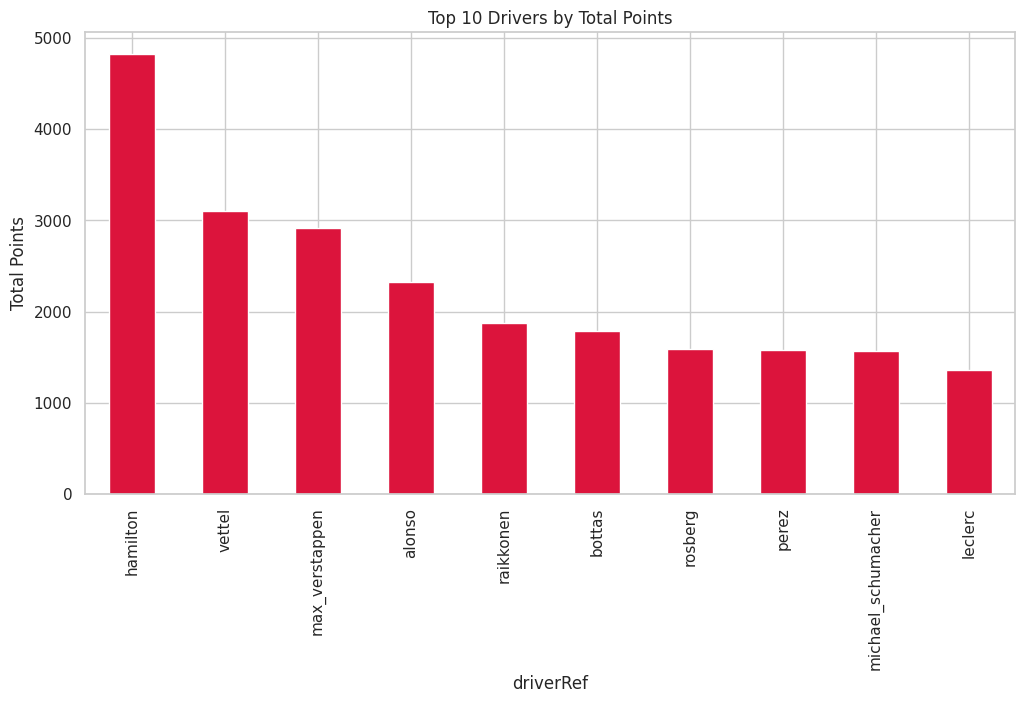

In [16]:
#Exploratory Data Analysis

#(1) Top Drivers by Points
top_drivers = merged.groupby('driverRef')['points'].sum().sort_values(ascending=False).head(10)
top_drivers.plot(kind='bar', color='crimson')
plt.title("Top 10 Drivers by Total Points")
plt.ylabel("Total Points")
plt.show()

In [19]:
print(merged.columns)

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'driverRef', 'number_y', 'code',
       'forename', 'surname', 'dob', 'nationality_x', 'url_x',
       'constructorRef', 'driver', 'nationality_y', 'url_y', 'year', 'round',
       'circuitId', 'team'],
      dtype='object')


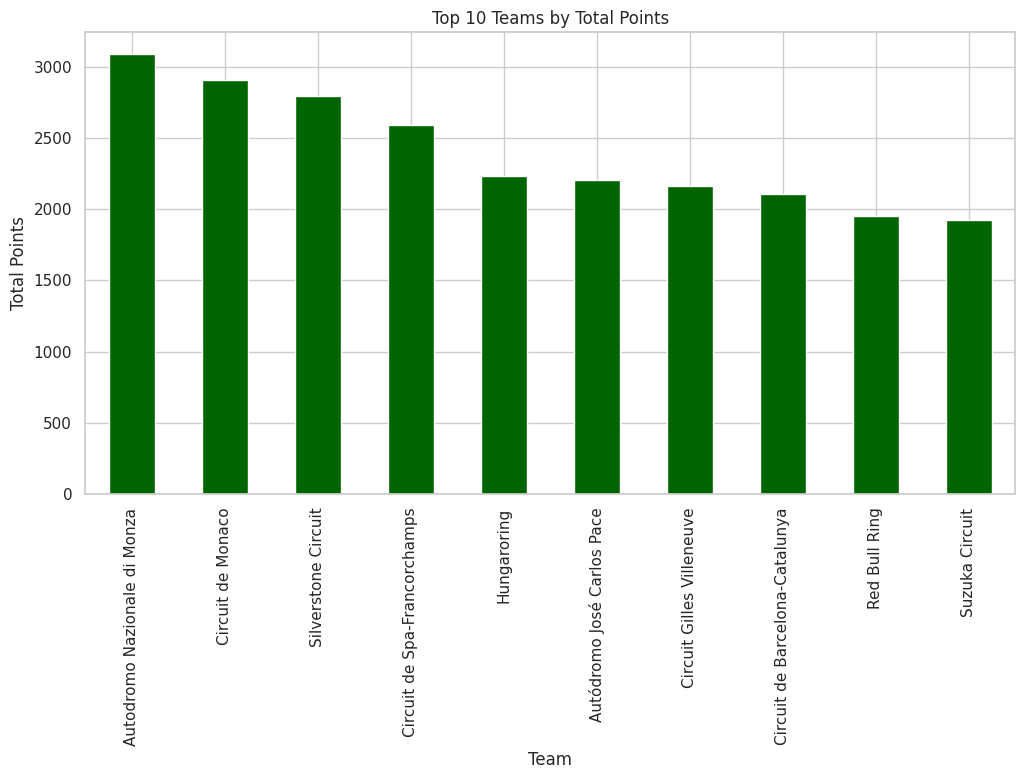

In [20]:
import matplotlib.pyplot as plt

# Top 10 teams by total points
team_points = merged.groupby('team')['points'].sum().sort_values(ascending=False).head(10)

# Plot
team_points.plot(kind='bar', color='darkgreen')
plt.title("Top 10 Teams by Total Points")
plt.ylabel("Total Points")
plt.xlabel("Team")
plt.show()

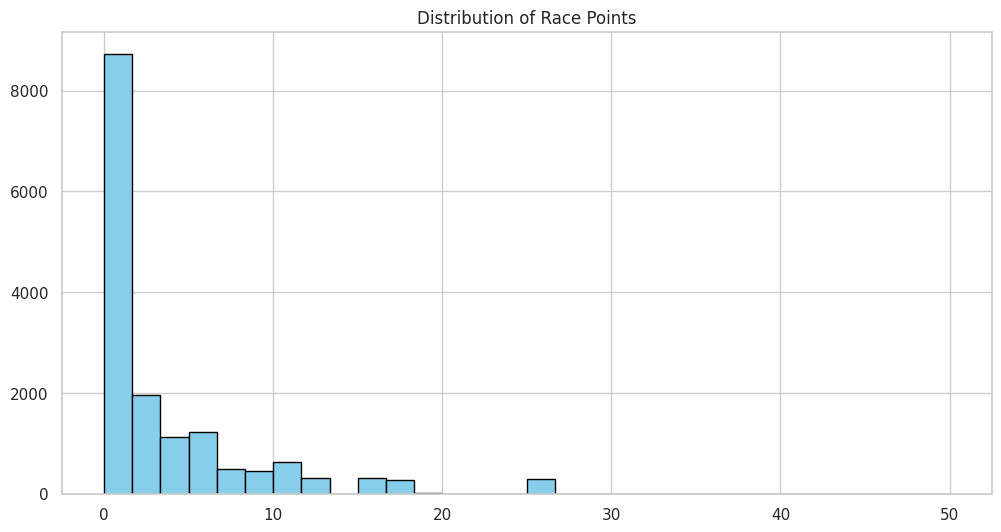

In [21]:
#(3) Points Distribution

plt.hist(merged['points'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Race Points")
plt.show()


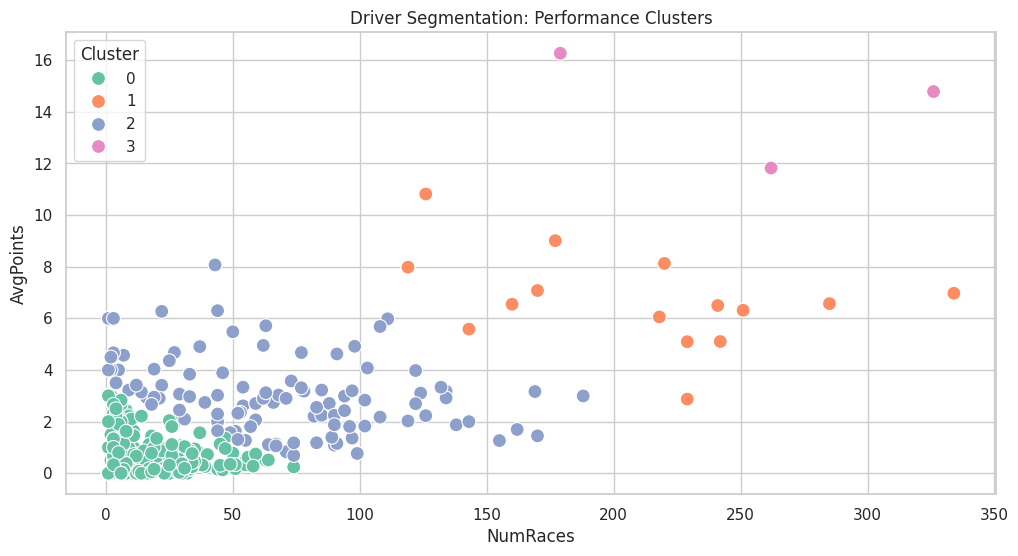

In [22]:
#Clustering (Driver Segmentation)

driver_stats = merged.groupby('driverRef').agg({
    'points': ['mean','sum'],
    'raceId': 'count'
}).reset_index()
driver_stats.columns = ['Driver','AvgPoints','TotalPoints','NumRaces']

# Scale and cluster
scaler = StandardScaler()
scaled = scaler.fit_transform(driver_stats[['AvgPoints','TotalPoints','NumRaces']])

kmeans = KMeans(n_clusters=4, random_state=42)
driver_stats['Cluster'] = kmeans.fit_predict(scaled)

sns.scatterplot(data=driver_stats, x='NumRaces', y='AvgPoints', hue='Cluster', palette='Set2', s=100)
plt.title("Driver Segmentation: Performance Clusters")
plt.show()


In [23]:
#Predictive Modeling (Random Forest Regression)
X = merged[['position','year']]
y = merged['points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, pred))


MSE: 0.21273444221255777


In [27]:
!pip install prophet --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 109.4 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1.7
    Uninstalling prophet-1.1.7:
      Successfully uninstalled prophet-1.1.7


In [5]:
!pip install prophet --upgrade


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns

sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = [12,6]

In [10]:
drivers = pd.read_csv("/content/f1_data/drivers.csv")
constructors = pd.read_csv("/content/f1_data/constructors.csv")
races = pd.read_csv("/content/f1_data/races.csv")
results = pd.read_csv("/content/f1_data/results.csv")
circuits = pd.read_csv("/content/f1_data/circuits.csv")

In [11]:
merged = results.merge(drivers, on='driverId', how='left') \
                .merge(constructors, on='constructorId', how='left') \
                .merge(races[['raceId','year','circuitId']], on='raceId', how='left') \
                .merge(circuits[['circuitId','name']], on='circuitId', how='left')

# Rename columns for clarity
merged.rename(columns={'name_x':'driver_name', 'name_y':'team', 'surname':'driver_surname'}, inplace=True)

# Quick check
print(merged[['year','team','points']].head())

   year                            team  points
0  2008  Albert Park Grand Prix Circuit    10.0
1  2008  Albert Park Grand Prix Circuit     8.0
2  2008  Albert Park Grand Prix Circuit     6.0
3  2008  Albert Park Grand Prix Circuit     5.0
4  2008  Albert Park Grand Prix Circuit     4.0


In [12]:
team_yearly = merged.groupby(['year','team'])['points'].sum().reset_index()

# Check top teams
team_yearly.sort_values(['points'], ascending=False).head(10)

,year,team,points
1049,2021,Red Bull Ring,204.0
1028,2020,Red Bull Ring,204.0
1022,2020,Bahrain International Circuit,204.0
1029,2020,Silverstone Circuit,204.0
915,2014,Yas Marina Circuit,202.0
1094,2023,Silverstone Circuit,102.0
1101,2024,Autódromo José Carlos Pace,102.0
1100,2024,Autódromo Hermanos Rodríguez,102.0
1099,2024,Autodromo Nazionale di Monza,102.0
1098,2024,Autodromo Enzo e Dino Ferrari,102.0


In [14]:
print(mercedes.shape)


(0, 2)


In [15]:
print(team_yearly['team'].unique())

['Autodromo Nazionale di Monza' 'Circuit Bremgarten' 'Circuit de Monaco'
 'Circuit de Spa-Francorchamps' 'Indianapolis Motor Speedway'
 'Reims-Gueux' 'Silverstone Circuit' 'Circuit de Pedralbes' 'Nürburgring'
 'Circuit Park Zandvoort' 'Rouen-Les-Essarts'
 'Autódromo Juan y Oscar Gálvez' 'Aintree' 'Pescara Circuit' 'Ain Diab'
 'Circuito da Boavista' 'AVUS' 'Monsanto Park Circuit'
 'Sebring International Raceway' 'Riverside International Raceway'
 'Watkins Glen' 'Prince George Circuit' 'Autódromo Hermanos Rodríguez'
 'Brands Hatch' 'Zeltweg' 'Charade Circuit' 'Kyalami' 'Le Mans'
 'Mosport International Raceway' 'Circuit Mont-Tremblant' 'Jarama'
 'Montjuïc' 'Hockenheimring' 'Red Bull Ring' 'Circuit Paul Ricard'
 'Nivelles-Baulers' 'Autódromo José Carlos Pace' 'Scandinavian Raceway'
 'Zolder' 'Dijon-Prenois' 'Fuji Speedway' 'Long Beach'
 'Autódromo Internacional Nelson Piquet' 'Circuit Gilles Villeneuve'
 'Autodromo Enzo e Dino Ferrari' 'Las Vegas Street Circuit'
 'Detroit Street Circuit' 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Top Teams: Index(['ferrari', 'mercedes', 'red_bull', 'mclaren', 'williams'], dtype='object', name='team')


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


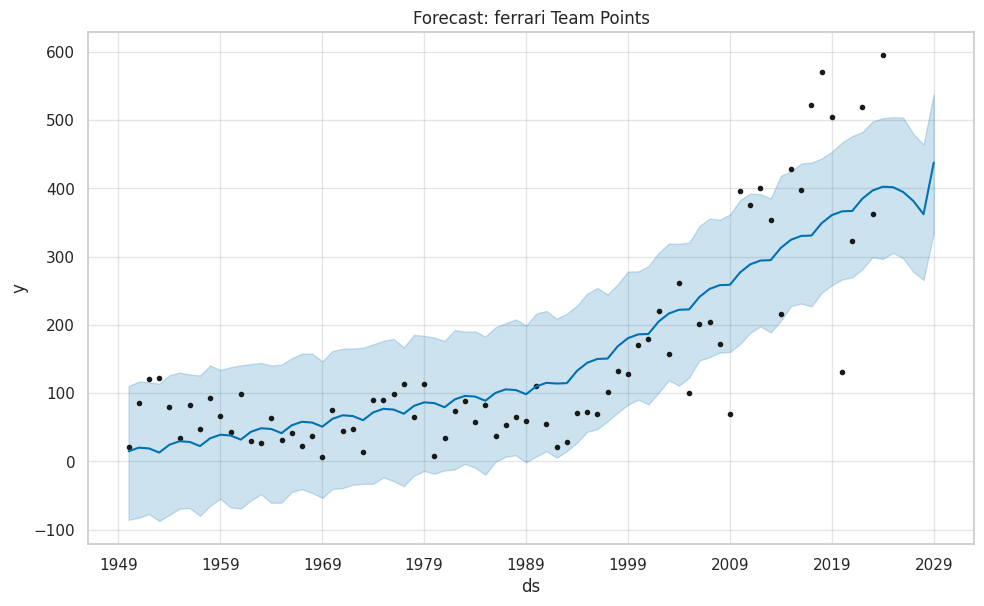

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


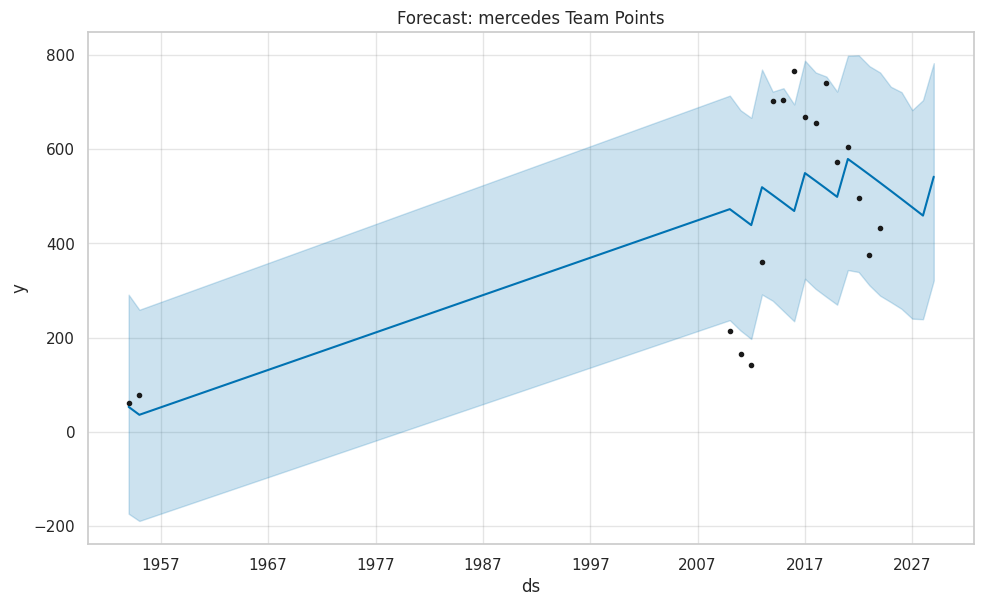

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


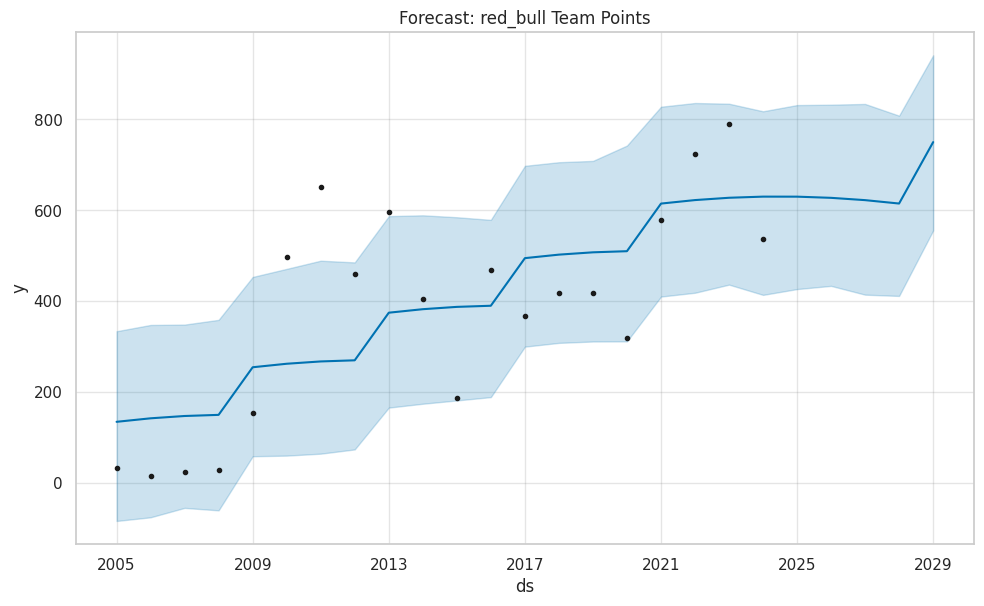

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


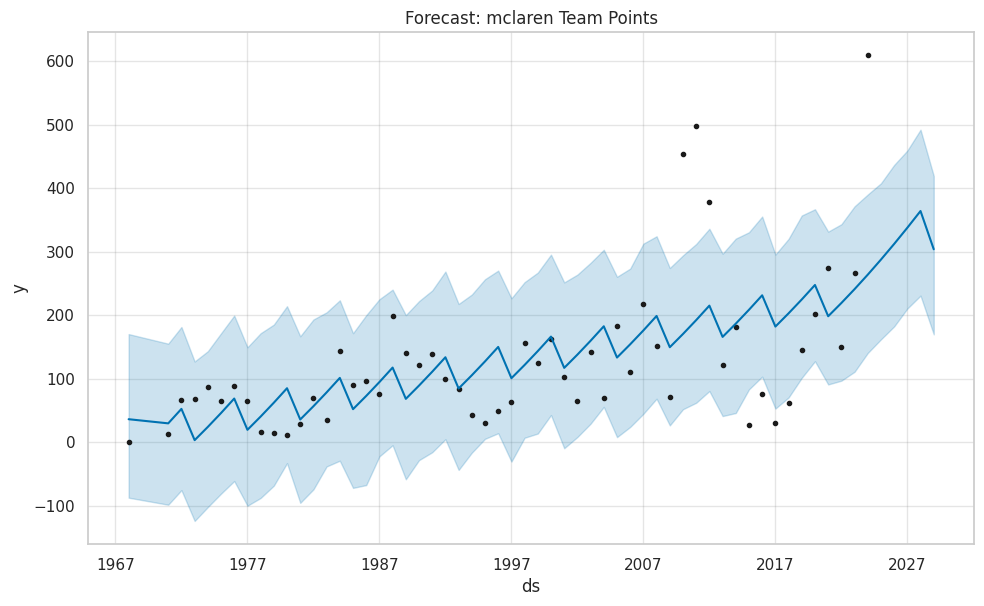

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


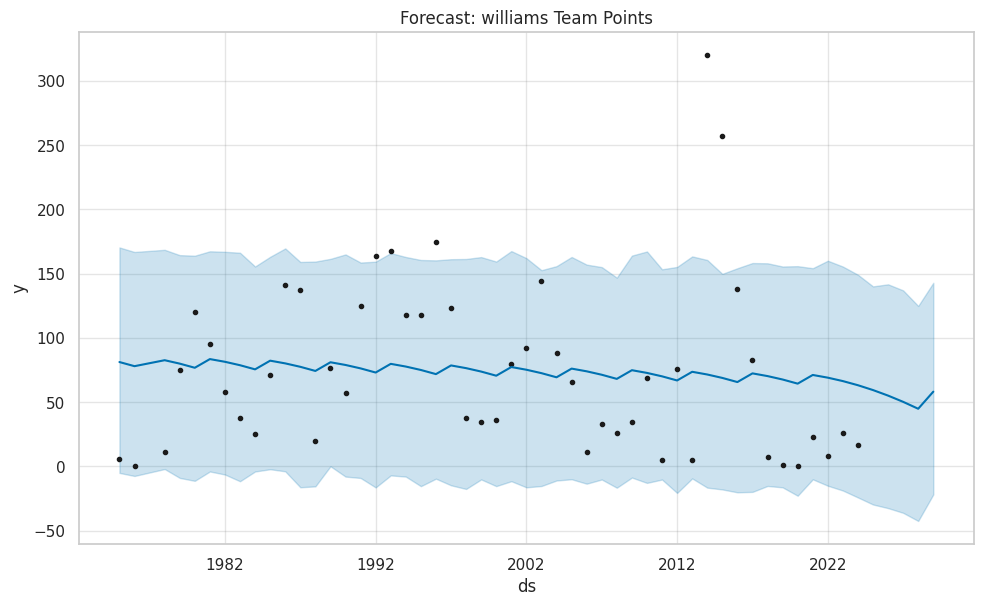

In [17]:
# Merge results with constructors to get team names
merged = results.merge(constructors, left_on='constructorId', right_on='constructorId', how='left')

# Merge with races to get year
merged = merged.merge(races[['raceId','year']], on='raceId', how='left')

# Keep only necessary columns
merged = merged[['year','constructorRef','points']]

# Aggregate yearly points per team
team_yearly = merged.groupby(['year','constructorRef'])['points'].sum().reset_index()
team_yearly.rename(columns={'constructorRef':'team'}, inplace=True)

# Check top 5 teams overall
top_teams = team_yearly.groupby('team')['points'].sum().sort_values(ascending=False).head(5).index
print("Top Teams:", top_teams)

# Forecast each top team
for team_name in top_teams:
    team_df = team_yearly[team_yearly['team']==team_name][['year','points']].rename(columns={'year':'ds','points':'y'})
    team_df['ds'] = pd.to_datetime(team_df['ds'], format='%Y')

    if team_df.shape[0] < 2:
        print(f"Not enough data to forecast {team_name}")
        continue

    model = Prophet(yearly_seasonality=True)
    model.fit(team_df)

    future = model.make_future_dataframe(periods=5, freq='Y')
    forecast = model.predict(future)

    # Plot forecast
    model.plot(forecast)
    plt.title(f"Forecast: {team_name} Team Points")
    plt.show()

In [19]:
# 1️⃣ Merge necessary datasets
# Merge results with drivers to get driver names
merged = results.merge(drivers[['driverId','forename','surname']], on='driverId', how='left')
merged['driver_name'] = merged['forename'] + " " + merged['surname']

# Merge with constructors to get team names
merged = merged.merge(constructors[['constructorId','name']], on='constructorId', how='left')
merged.rename(columns={'name':'team'}, inplace=True)

# Merge with races to get year
merged = merged.merge(races[['raceId','year']], on='raceId', how='left')

# Keep only relevant columns
merged = merged[['year','team','driver_name','points']]

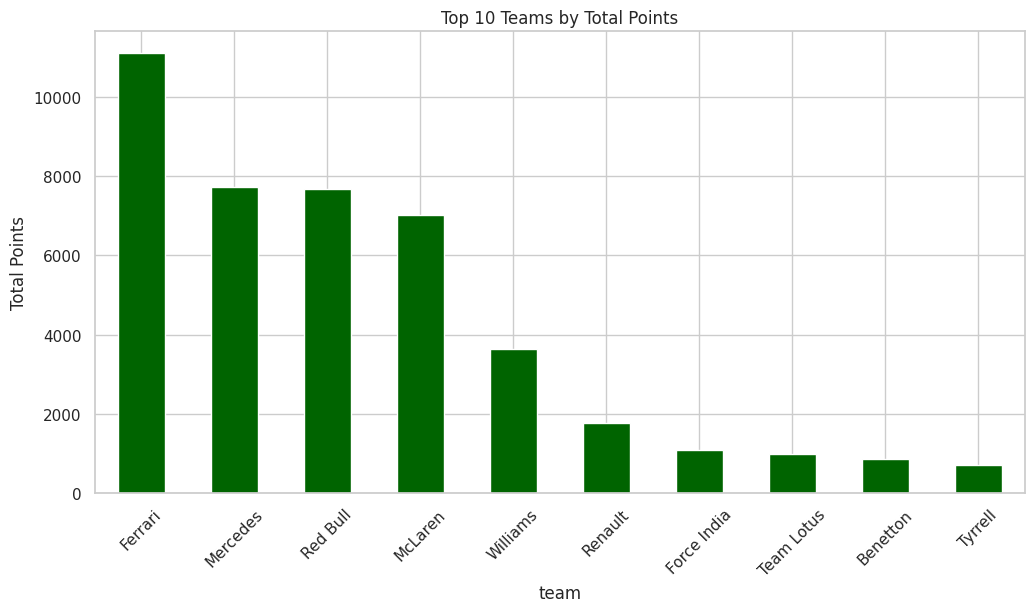

In [20]:
# 2️⃣ Top-performing teams
top_teams = merged.groupby('team')['points'].sum().sort_values(ascending=False).head(10)
top_teams.plot(kind='bar', color='darkgreen')
plt.title("Top 10 Teams by Total Points")
plt.ylabel("Total Points")
plt.xticks(rotation=45)
plt.show()

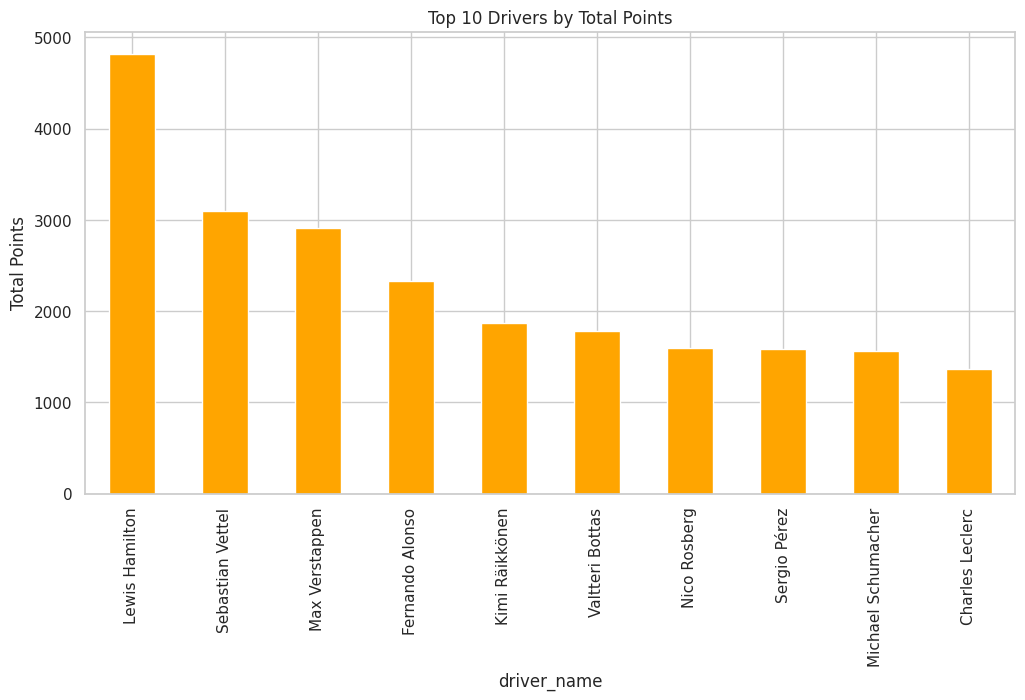

In [21]:
# 3️⃣ Top-performing drivers
top_drivers = merged.groupby('driver_name')['points'].sum().sort_values(ascending=False).head(10)
top_drivers.plot(kind='bar', color='orange')
plt.title("Top 10 Drivers by Total Points")
plt.ylabel("Total Points")
plt.xticks(rotation=90)
plt.show()

In [23]:
# 4️⃣ Cluster Analysis (Driver Performance Tiers)
driver_points = merged.groupby('driver_name')['points'].sum().reset_index()



In [28]:
# Merge results with drivers
merged = results.merge(drivers[['driverId','forename','surname']], on='driverId', how='left')
merged['driver_name'] = merged['forename'] + " " + merged['surname']

# Merge with constructors
merged = merged.merge(constructors[['constructorId','name']], on='constructorId', how='left')
merged.rename(columns={'name':'team'}, inplace=True)

# Merge with races for year
merged = merged.merge(races[['raceId','year']], on='raceId', how='left')

# Keep only relevant columns
merged = merged[['year','team','driver_name','points']]

# Drop any rows with missing values
merged = merged.dropna()
print(merged.head())

   year        team        driver_name  points
0  2008     McLaren     Lewis Hamilton    10.0
1  2008  BMW Sauber      Nick Heidfeld     8.0
2  2008    Williams       Nico Rosberg     6.0
3  2008     Renault    Fernando Alonso     5.0
4  2008     McLaren  Heikki Kovalainen     4.0
